# AI - MLP Project

## Function output prediction

### Ahmad Salimi - 97106013

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import MinMaxScaler
import inspect
from sys import stdout

In [200]:
class LossHistory(keras.callbacks.Callback):

    def __init__(self, learner):
        self.learner = learner
        self.epoch = 1

    def on_train_begin(self, logs={}):
        self.data = {'loss': [], 'lr': []}
    
    def on_epoch_end(self, batch, logs={}):
        self.data['loss'].append(logs.get('loss'))
        self.data['lr'].append(self.learner.lr)

        if self.epoch % 20 == 0:
            self.learner.print_status(self.epoch, logs.get('loss'))
        self.epoch += 1

In [219]:
class FunctionLearner:
    
    def __init__(self, train_data=None, function=None, data_size=None, train_domain_low=None, train_domain_high=None, neurons=[20, 20], noise_sigma=None):
        self.function = function
        self.feature_scaler = MinMaxScaler()
        self.target_scaler = MinMaxScaler()
        self.X, self.y = self.get_dataset(train_data, data_size, train_domain_low, train_domain_high, noise_sigma)
        self.model = self.create_model(neurons)
        self.lr = 0.01
        self.alpha = 0.9
    
    def get_feature_dimension(self):
        return len(inspect.signature(self.function).parameters)
    
    def get_dataset(self, data, size:int, low, high, noise_sigma):
        if data is not None:
            X = data[data.columns[:-1]].values
            y = data[data.columns[-1:]].values
            self.function = lambda x: y if x is X else None
        else:
            X, y = self.create_random_dataset(size, low, high, noise_sigma)

        self.feature_scaler.fit(X)
        self.target_scaler.fit(y)
        return X, y
    
    def create_random_dataset(self, size:int, low, high, noise_sigma):
        feature_shape = (size, self.get_feature_dimension())
        X = np.random.uniform(low, high, feature_shape)
        y = self.function(*X.T).reshape(size, 1)

        if noise_sigma:
            y += np.random.normal(scale=noise_sigma, size=(size, 1))
        return X, y

    def step_decay(self, epoch):
        if epoch % 500 == 0:
            self.lr *= 0.9
        return self.lr
    
    def create_model(self, neurons):
        model = Sequential()
        model.add(Dense(neurons[0], input_dim=self.get_feature_dimension(), activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(neurons[0], activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(1))

        opt = keras.optimizers.adam(learning_rate=0.01)
        model.compile(optimizer=opt, loss='mse')
        return model

    def plot_axis(self, x, axis, title=None):
        plt.figure(figsize=(15, 10))

        if title:
            plt.title(title)
        
        plt.scatter(x[:, axis], self.predict(x).reshape(x.shape[0],) - self.function(*x.T), color='red', label='prediction error', s=5, zorder=1)
        plt.scatter(self.X[:, axis], self.y.reshape(self.X.shape[0],) - self.function(*self.X.T), color='green', label='train error', s=5, zorder=2)

        plt.grid()
        plt.legend()
    
    def plot_result(self, x, title=None, xlim=None, ylim=None):
        if self.get_feature_dimension() > 1:
            raise Exception("Cannot plot more than 2d")
        
        plt.figure(figsize=(15, 10))

        if title:
            plt.title(title)
        
        plt.scatter(x, self.function(x), color='skyblue', label='original', s=90, zorder=1)
        plt.scatter(self.X, self.y, color='green', label='train data', s=50, zorder=2)
        plt.scatter(x, self.predict(x), color='red', label='predicted', s=5, zorder=3)
        plt.grid()
        if xlim:
            plt.xlim(xlim)
        if ylim:
            plt.ylim(ylim)
        plt.legend()

    def plot_history(self, name, ylim=None):
        plt.figure(figsize=(15, 10))
        plt.plot(np.arange(len(self.loss_history.data[name])), self.loss_history.data[name], color='skyblue', label='name', linewidth=3, zorder=1)
        plt.grid()
        if ylim:
            plt.ylim(ylim)
        plt.legend()
    
    def print_status(self, epoch, loss):
        stdout.write(f"\repoch: {epoch:4} - loss: {loss:.5e}")
        stdout.flush()
    
    def learn(self, epochs):
        learning_rate = LearningRateScheduler(self.step_decay)
        self.loss_history = LossHistory(self)

        self.model.fit(
            self.feature_scaler.transform(self.X), 
            self.target_scaler.transform(self.y), 
            batch_size=10, epochs=epochs, 
            callbacks=[self.loss_history, learning_rate], 
            verbose=0, validation_split=0.1)

        self.print_status(epochs, self.loss_history.data["loss"][-1])
        print()
    
    def mse(self, X, Y):
        return ((X - Y) ** 2).mean()

    def error(self, X):
        prediction = self.predict(X)
        return self.mse(prediction, self.function(*X.T).reshape(prediction.shape))
    
    def predict(self, X):
        return self.target_scaler.inverse_transform(
            self.model.predict(
                self.feature_scaler.transform(X)))

$\mathcal{f}(x) = 554x + 2$

In [171]:
learner = FunctionLearner(function=lambda x: 554 * x + 2, data_size=20, train_domain_low=-10, train_domain_high=10, neurons=[4, 1])

In [172]:
learner.learn(500)

epoch:  500 - loss: 1.44409e-15

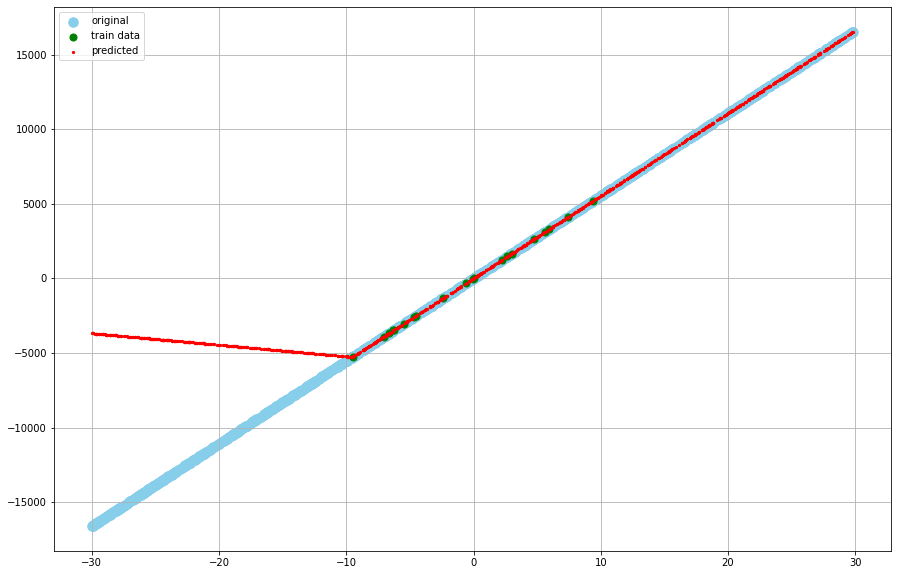

In [173]:
learner.plot_result(np.random.uniform(-30, 30, (1000, 1)))

$ \mathcal{f}(x) = \sin(x) $

In [181]:
learner = FunctionLearner(function=lambda x: np.sin(x), data_size=200, train_domain_low=-10, train_domain_high=10, neurons=[20, 20])

In [182]:
learner.learn(2000)

epoch: 2000 - loss: 1.07736e-03

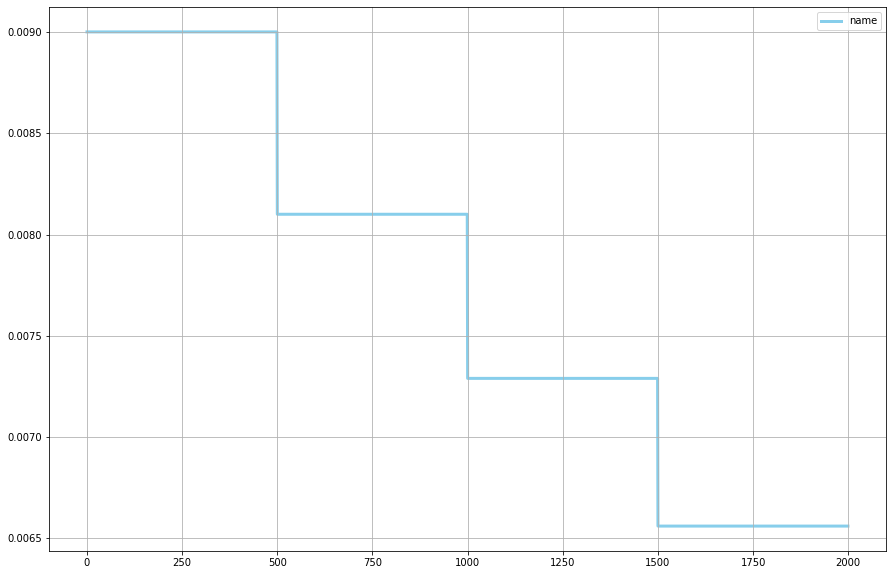

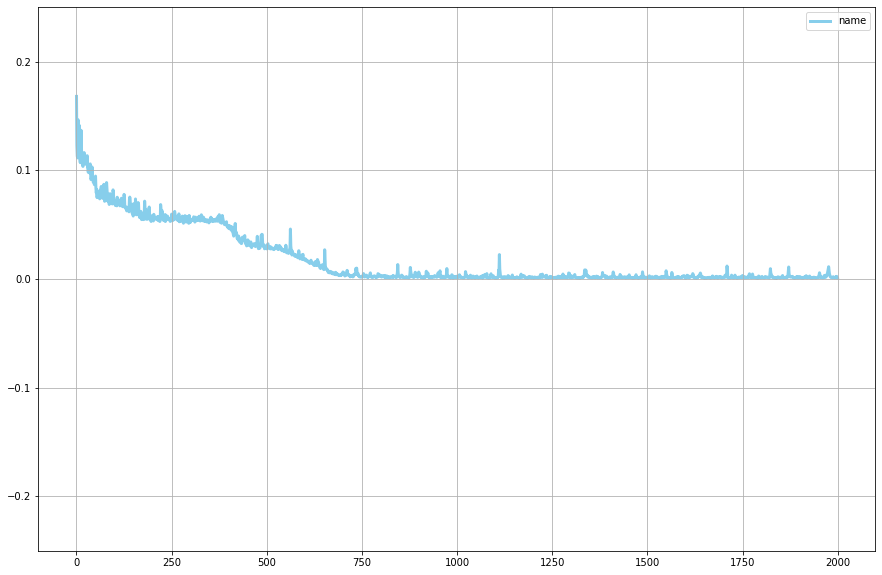

In [183]:
learner.plot_history('lr')
learner.plot_history('loss', ylim=(-.25, .25))

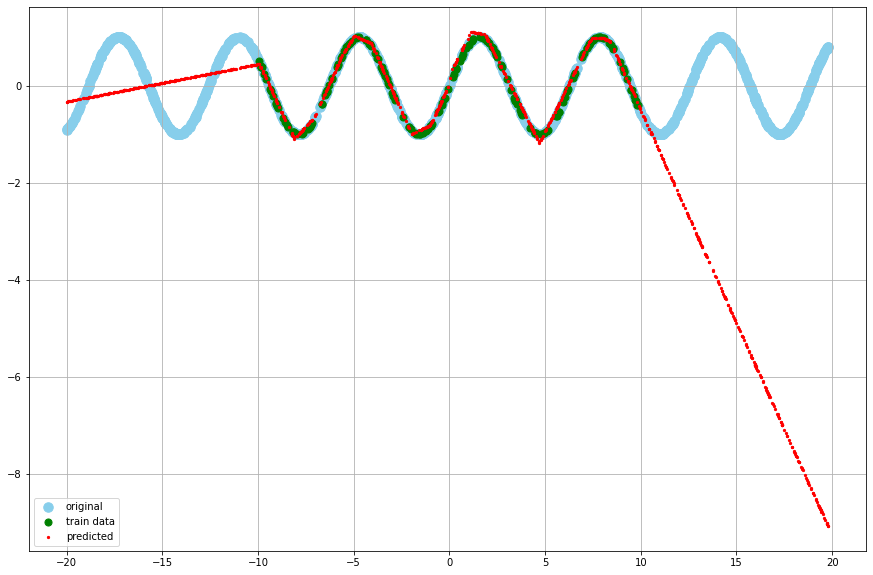

In [184]:
learner.plot_result(np.random.uniform(-20, 20, (1000, 1)))

$ \mathcal{f}(x) = 50x^3 + 2500 $

In [185]:
learner = FunctionLearner(function=lambda x: 50 * x ** 3 + 2500, data_size=100, train_domain_low=-10, train_domain_high=10, neurons=[20, 20])

In [186]:
learner.learn(2000)

epoch: 2000 - loss: 2.93476e-05

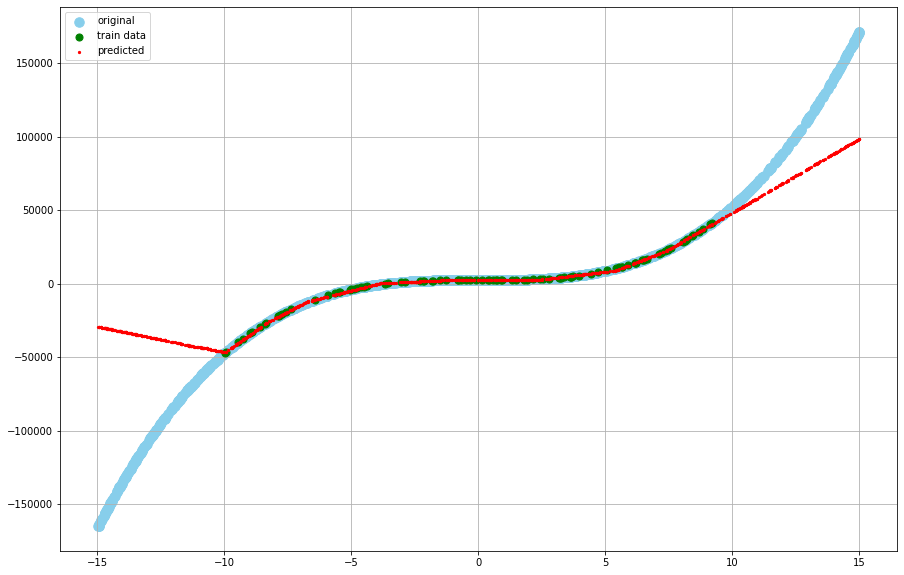

In [187]:
learner.plot_result(np.random.uniform(-15, 15, (1000, 1)))

$ \mathcal{f}(x) = x^2\sin(x) $

In [216]:
learner = FunctionLearner(function=lambda x: x ** 2 * np.sin(x), data_size=500, train_domain_low=-10, train_domain_high=10, neurons=[22, 22])

In [217]:
learner.learn(2000)

epoch: 2000 - loss: 6.31920e-04

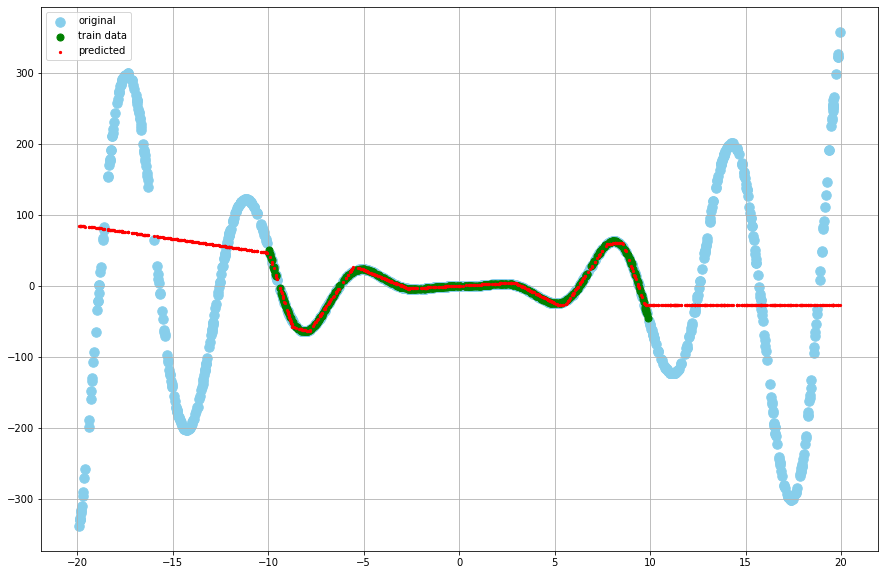

In [218]:
learner.plot_result(np.random.uniform(-20, 20, (1000, 1)))

start training on noise 0.05
epoch: 2000 - loss: 1.90391e-03
start training on noise 0.1
epoch: 2000 - loss: 1.68144e-02
start training on noise 0.15000000000000002
epoch: 2000 - loss: 3.49030e-02
start training on noise 0.2
epoch: 2000 - loss: 2.91352e-02
start training on noise 0.25
epoch: 2000 - loss: 8.14869e-03
start training on noise 0.3
epoch: 2000 - loss: 1.81095e-02
start training on noise 0.35000000000000003
epoch: 2000 - loss: 3.20868e-02
start training on noise 0.4
epoch: 2000 - loss: 2.04110e-02
start training on noise 0.45
epoch: 2000 - loss: 9.18736e-03


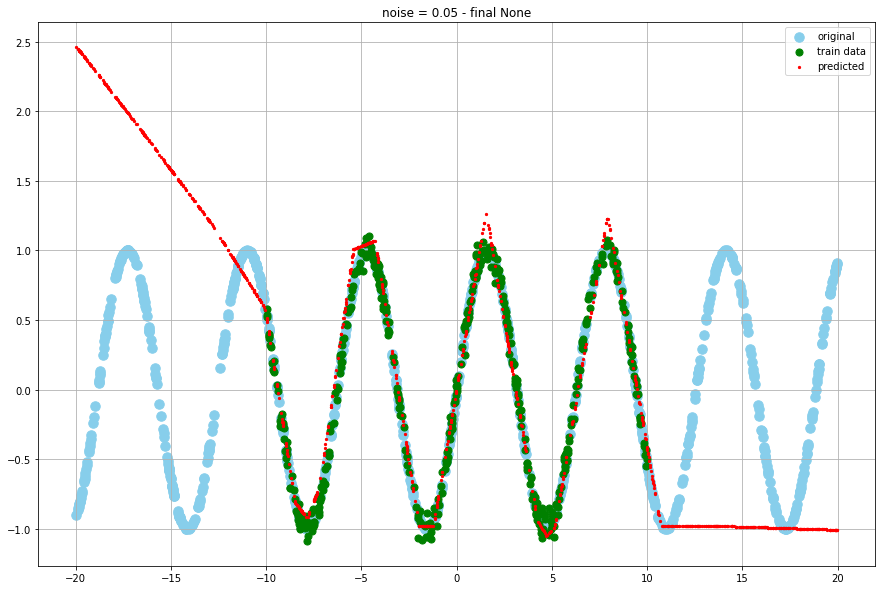

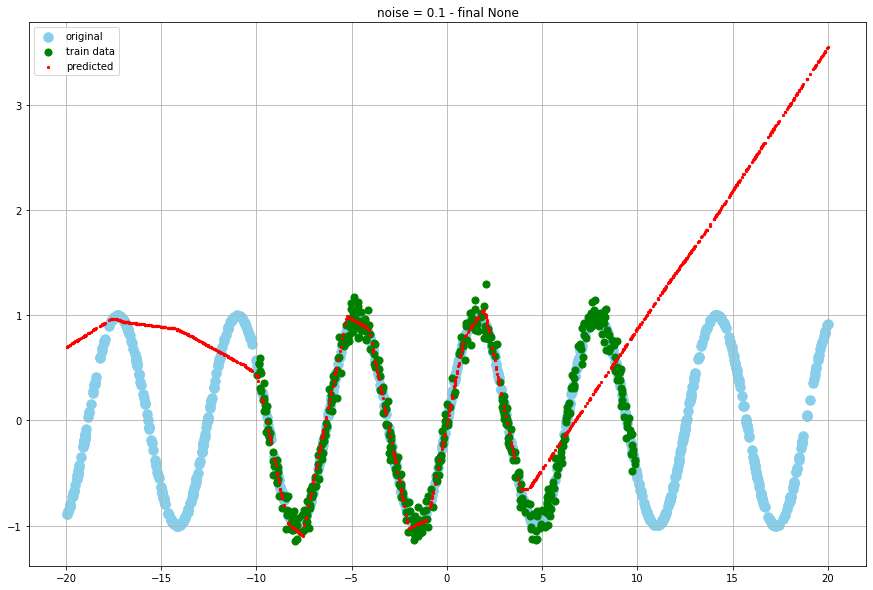

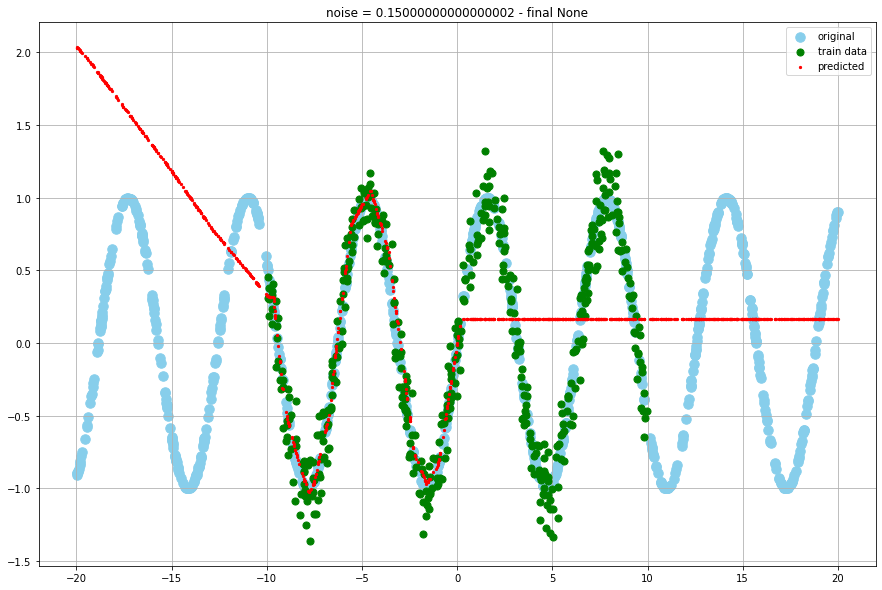

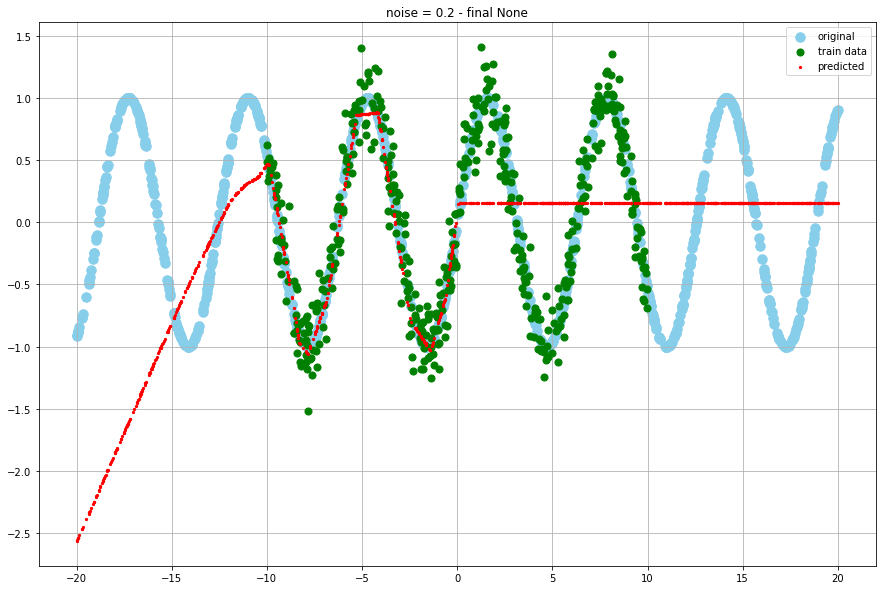

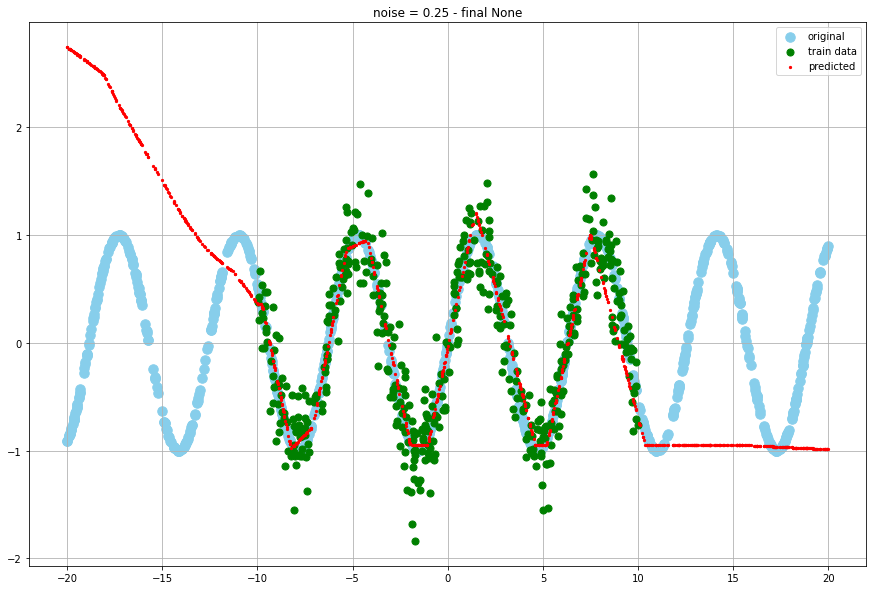

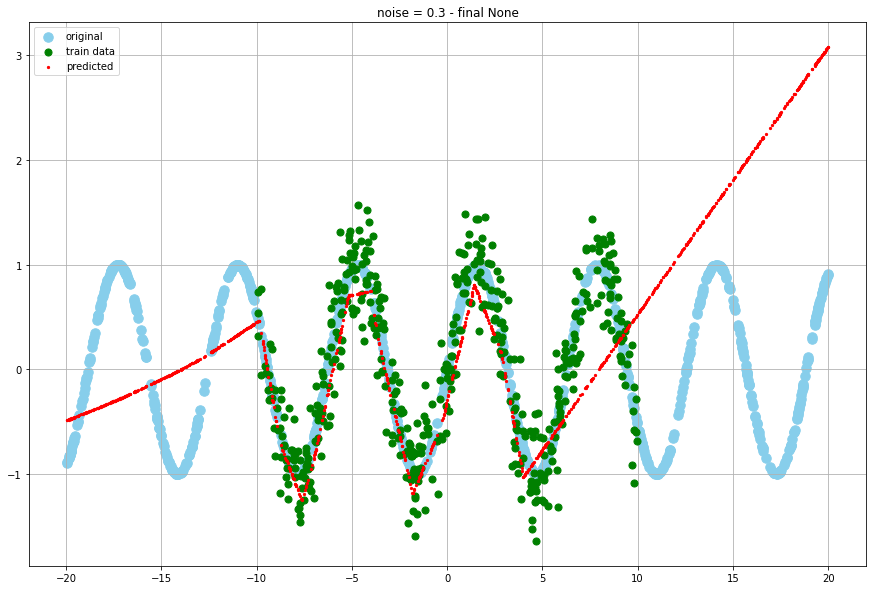

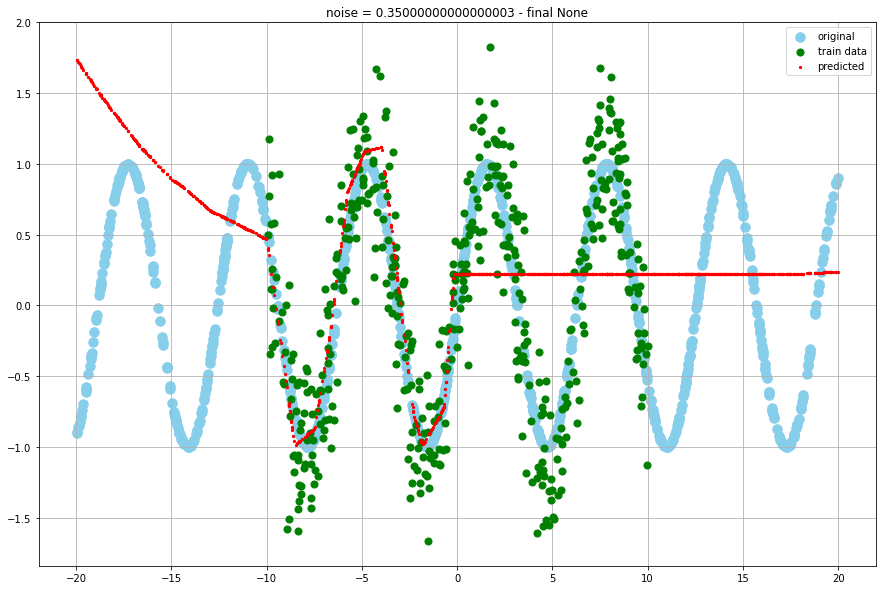

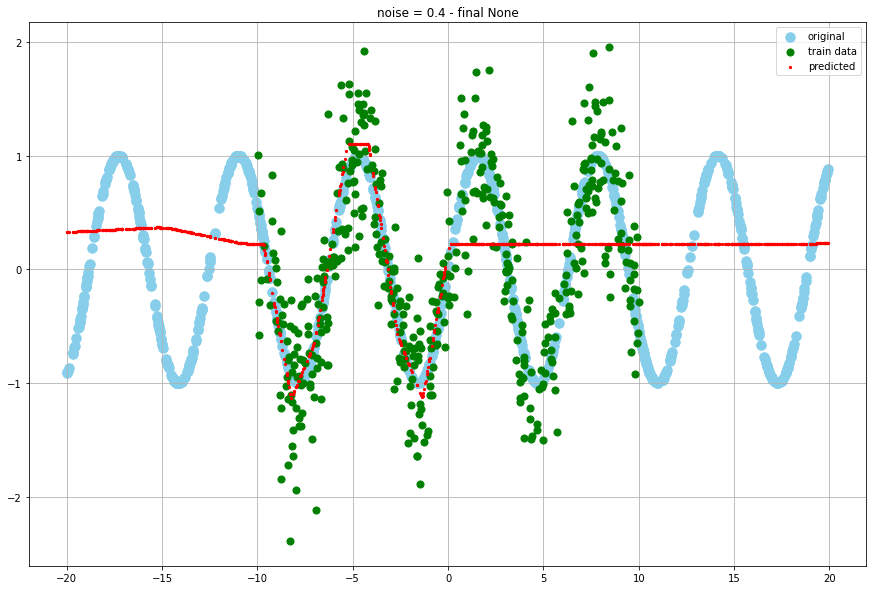

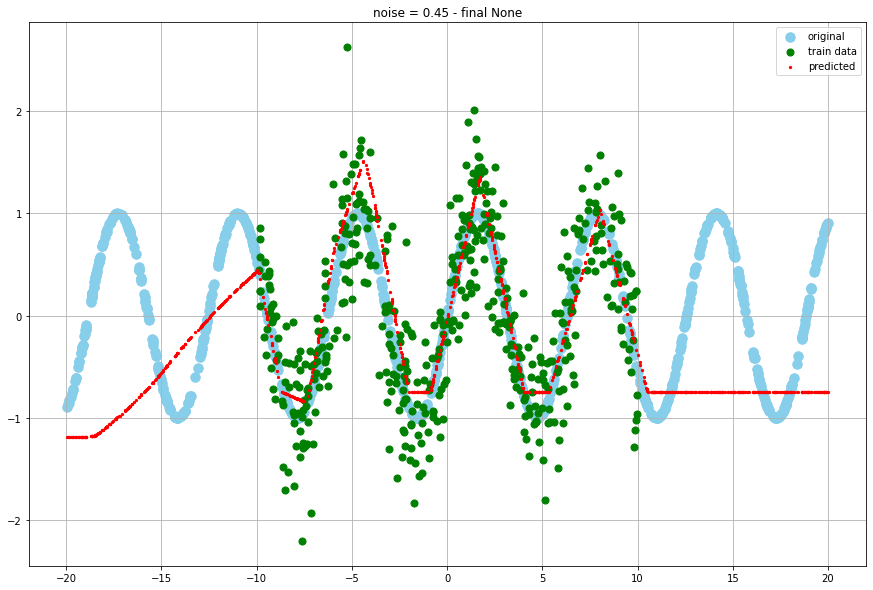

In [282]:
for noise in np.arange(0.05, 0.5, 0.05):
    print(f'start training on noise {noise}')
    learner = FunctionLearner(function=lambda x: np.sin(x), data_size=500, train_domain_low=-10, train_domain_high=10, noise_sigma=noise, neurons=(25, 25))
    learner.learn(2000)
    learner.plot_result(np.random.uniform(-20, 20, (1000, 1)), f'noise = {noise} - final {loss}')

$ \mathcal{f}(x, y) = x^2 + y^3 - 3xy^2 $

In [220]:
learner = FunctionLearner(function=lambda x, y: x**2 + y**3 - 3*x*y**2 , data_size=500, train_domain_low=(-5, -5), train_domain_high=(5, 5), neurons=[32, 32])

In [224]:
learner.learn(50)

epoch:   50 - loss: 2.96818e-05


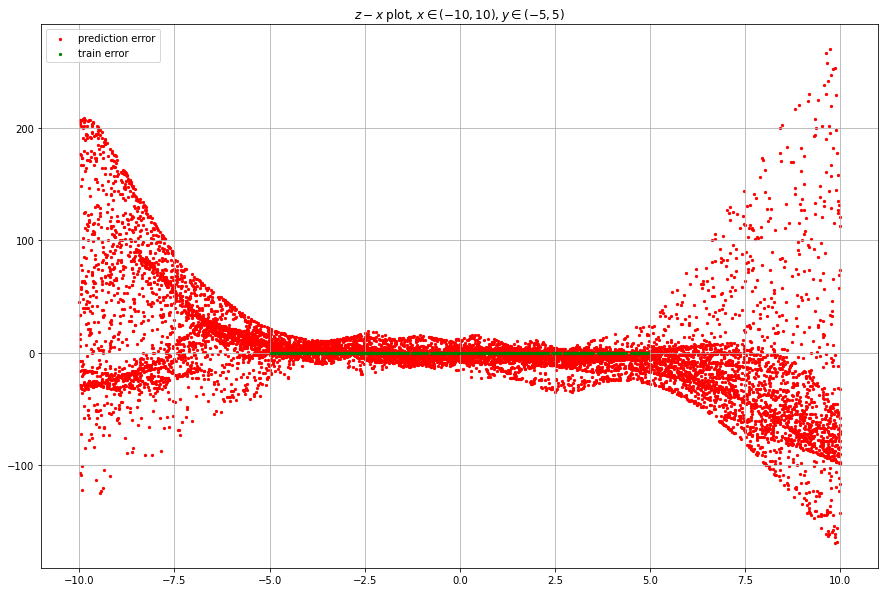

In [225]:
learner.plot_axis(np.random.uniform((-10, -5), (10, 5), (10000, 2)), 0, "$z-x$ plot, $x \\in (-10, 10), y \\in (-5, 5)$")

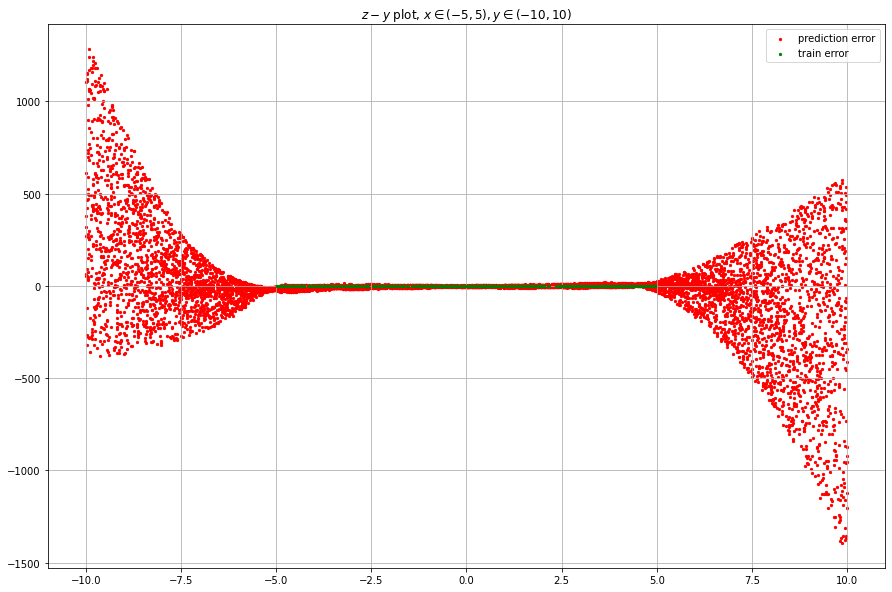

In [226]:
learner.plot_axis(np.random.uniform((-5, -10), (5, 10), (10000, 2)), 1, "$z-y$ plot, $x \\in (-5, 5), y \\in (-10, 10)$")

In [227]:
learner.error(learner.X)

53.588026365908895

In [228]:
learner.error(np.random.uniform((-10, -10), (10, 10), (10000, 2)))

172295.02271168432

$ \mathcal{f}(x, y, z) = x \log{y} - z^2 \sin(ye^x) $

In [242]:
learner = FunctionLearner(function=lambda x, y, z: x * np.log(y) - z ** 2 * np.sin(np.exp(x) * y), data_size=500, train_domain_low=(-5, 0, -5), train_domain_high=(5, 10, 5), neurons=[55, 28])

In [243]:
learner.learn(500)

epoch:  500 - loss: 7.14681e-03


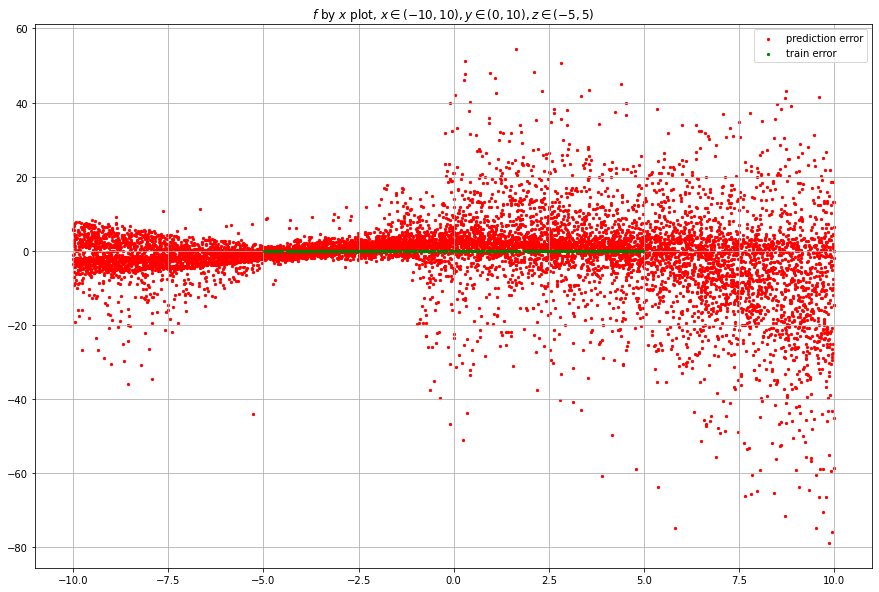

In [244]:
learner.plot_axis(np.random.uniform((-10, 0, -5), (10, 10, 5), (10000, 3)), 0, "$f$ by $x$ plot, $x \\in (-10, 10), y \\in (0, 10), z \\in (-5, 5) $")

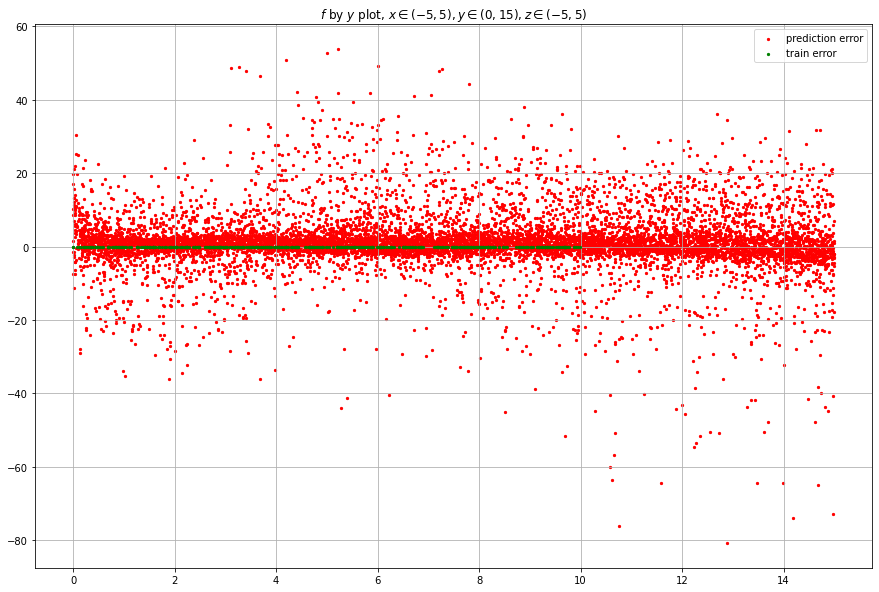

In [245]:
learner.plot_axis(np.random.uniform((-5, 0, -5), (5, 15, 5), (10000, 3)), 1, "$f$ by $y$ plot, $x \\in (-5, 5), y \\in (0, 15), z \\in (-5, 5) $")

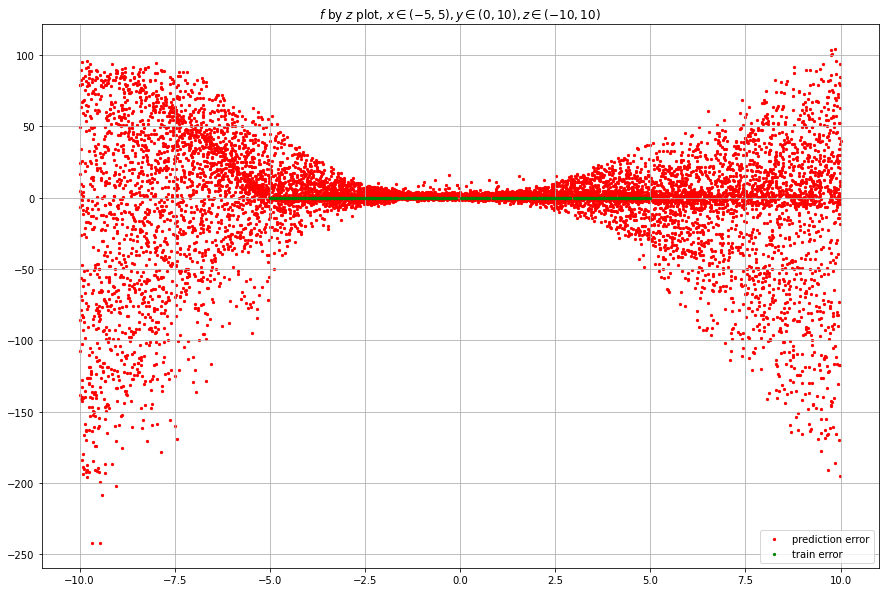

In [246]:
learner.plot_axis(np.random.uniform((-5, 0, -10), (5, 10, 10), (10000, 3)), 2, "$f$ by $z$ plot, $x \\in (-5, 5), y \\in (0, 10), z \\in (-10, 10) $")

In [247]:
learner.error(learner.X)

18.514636110669738

In [248]:
learner.error(np.random.uniform((-7, 0, -7), (7, 17, 7), (10000, 3)))

549.2993619455442

In [249]:
def plot(df):
    plt.figure(figsize=(15, 10))

    plt.plot(function_points['x'], function_points['y'])

    plt.grid()
    plt.show()

In [250]:
function_points = pd.read_csv('function.csv').drop_duplicates(subset='x')
function_points.head()

,x,y
0,74.899994,138.300003
1,75.899994,139.300003
2,76.899994,139.300003
3,77.899994,140.300003
4,79.899994,140.300003


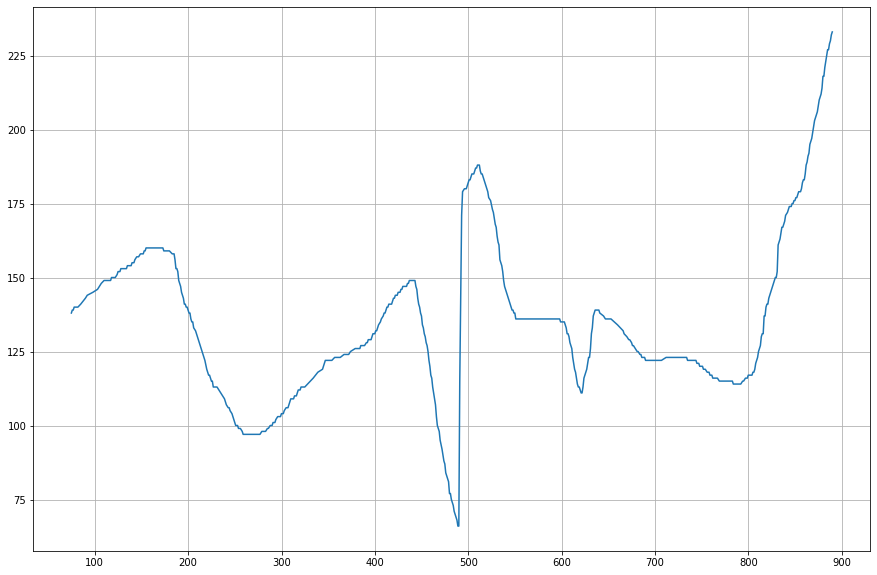

In [251]:
plot(function_points)

In [267]:
learner = FunctionLearner(train_data=function_points, neurons=[25, 25])

In [268]:
learner.learn(500)

epoch:  500 - loss: 1.10155e-02


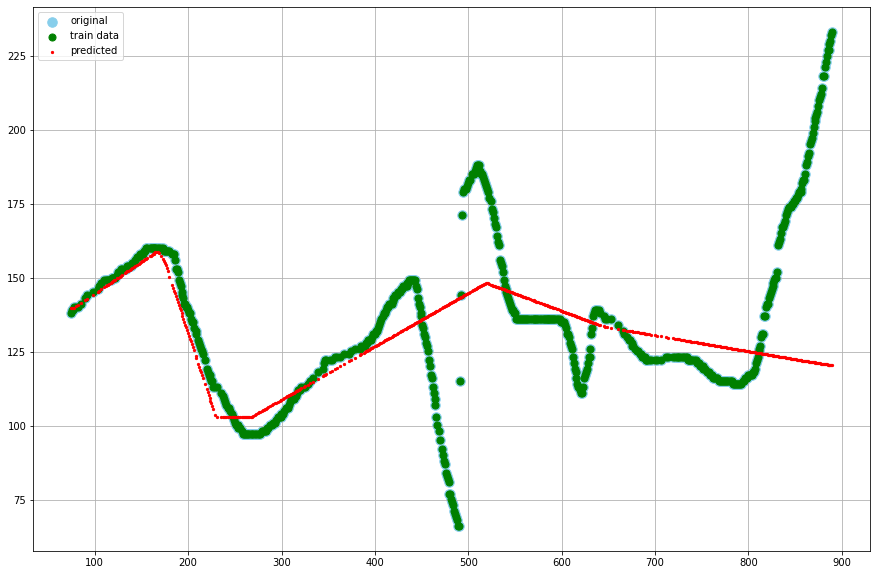

In [269]:
learner.plot_result(learner.X)

In [270]:
function_points = pd.read_csv('function2.csv').drop_duplicates(subset='x').sort_values('x')
function_points.head()

,x,y
0,1.899994,331.699982
1,2.899994,331.699982
4,3.899994,332.699982
5,4.899994,332.699982
7,5.899994,333.699982


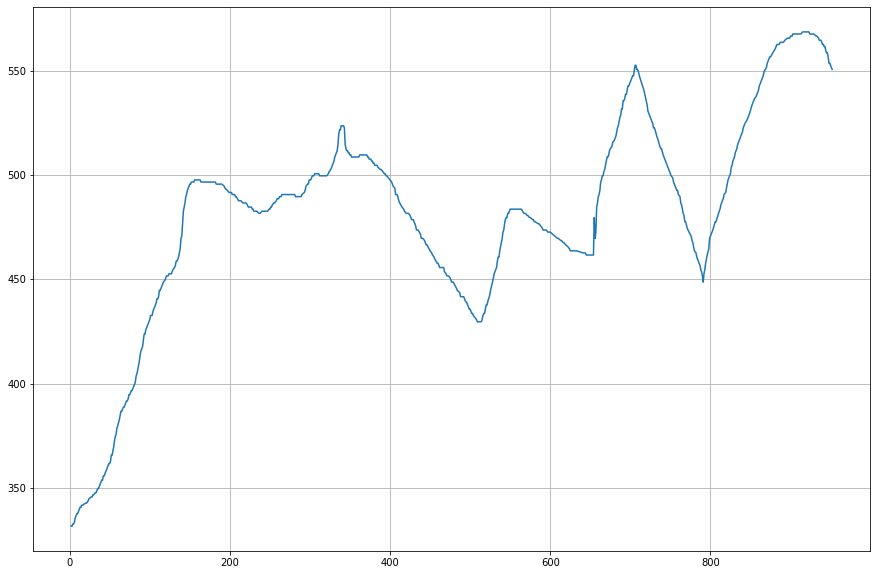

In [271]:
plot(function_points)

In [277]:
learner = FunctionLearner(train_data=function_points, neurons=[40, 40])

In [278]:
learner.learn(500)

epoch:  500 - loss: 1.25835e-03


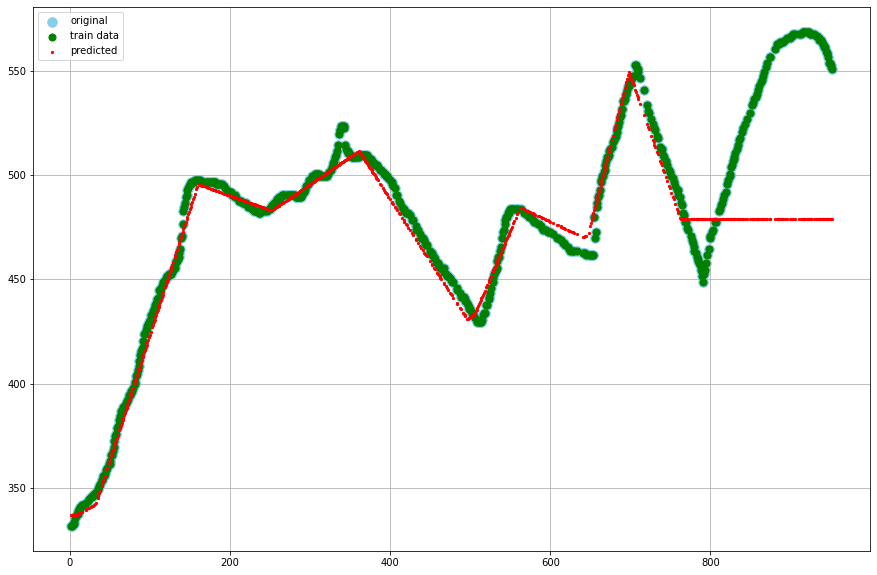

In [279]:
learner.plot_result(learner.X)